This notebook can be used to load raw ultraleap data, 
save cleaned dataframes for each block, 
and generate dataframes of distances for further feature extraction

Import public packages and functions

In [2]:
import os
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from itertools import compress


import openpyxl
from datetime import datetime
from scipy.spatial import distance
from scipy.ndimage import uniform_filter1d
import math
from scipy.signal import find_peaks, peak_prominences
import statistics as stat
import json
import traces

In [3]:
def get_repo_path_in_notebook():
    """
    Finds path of repo from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()
    repo_name = 'ultraleap_analysis'

    while path[-len(repo_name):] != 'ultraleap_analysis':

        path = os.path.dirname(path)

    return path


In [4]:
repo_path = get_repo_path_in_notebook()
code_path = os.path.join(repo_path, 'code')
os.chdir(code_path)

Import own functions

In [5]:
import import_data.import_and_convert_data as import_dat
import import_data.find_paths as find_paths
import import_data.preprocessing_meta_info as meta_info
import sig_processing.segment_tasks as tasks
import movement_calc.helpfunctions as hp

### Loading blocks for feature extraction

Reloading own functions

In [9]:
importlib.reload(import_dat)
importlib.reload(tasks)
importlib.reload(find_paths)
importlib.reload(meta_info)
importlib.reload(hp)

<module 'movement_calc.helpfunctions' from '/Users/arianm/Documents/GitHub/ultraleap_analysis/code/movement_calc/helpfunctions.py'>

Define variables of interest

In [680]:
folder = 'patientdata'
ls_cond = ['m1', 'm0s0', 'm0s1', 'm1s0', 'm1s1']
ls_cam = ['dt', 'vr',  'st']
# ls_task = ['ft', 'oc', 'ps', 'pt']
ls_side = ['left', 'right']
# subs = find_paths.find_available_subs(folder)

In [1099]:
subs = ['ul001']
ls_task = ['ft']
for sub in subs:
    for cond in ls_cond:
        for task in ls_task:
            try:
                files = os.listdir(os.path.join(repo_path, 'data','raw_blocks', sub, task, cond, 'dist'))

            except FileNotFoundError:
                continue 
            
            for file in files:
                if file == '.DS_Store':
                    continue

                # Load blocks from patients' blocks dir
                block = pd.read_csv(os.path.join(
                    repo_path, 'data', 'raw_blocks', sub, task, cond, 'dist', file))
                
                            

In [189]:
def new(block, task):

    if task in ['ft', 'oc']:

        features = ['num_events', 'max_amp', 'max_vel', 'mean_vel', 'tap_dur', 'rms', 'nrms']

        tap_features = {feat: [] for feat in features}

        min_idx, max_idx = hp.find_min_max(block, task)

        tap_features['num_events'] = (len(min_idx))

        for i in np.arange(0, len(min_idx[:-1])):

            try:
                distances = np.array(block.iloc[min_idx[i]:min_idx[i+1]]['index_tip_thumb_tip'])

            except KeyError:
                distances = np.array(block.iloc[min_idx[i]:min_idx[i+1]]['middle_tip_palm'])

            durations = np.array(block.iloc[min_idx[i]:min_idx[i+1]]['time'])

            tap_dur = block.iloc[min_idx[i+1]]['time'] - block.iloc[min_idx[i]]['time']


            df_dist = np.diff(distances)
            df_time = np.diff(durations)
            
            vel = abs(df_dist) / df_time

            tap_features['max_amp'].append(np.nanmax(distances))
            tap_features['max_vel'].append(np.nanmax(vel))
            tap_features['mean_vel'].append(np.nanmean(vel))
            tap_features['tap_dur'].append(tap_dur)
            tap_features['rms'].append(np.sqrt(np.nanmean(distances**2)))
            tap_features['nrms'].append((np.sqrt(np.nanmean(distances**2))) / tap_dur)


    # if task == 'ps':
    #     sup_idx, pro_idx = hp.find_min_max(block, task) # i.e.: sup = min, pro = max
    return 


In [191]:
def new_block(x = dict):

    features = ['num_events',
    'mean_max_amp', 'sd_max_amp', 'coef_var_max_amp', 'slope_max_amp',
    'mean_max_vel', 'sd_max_vel', 'coef_var_max_vel', 'slope_max_vel', 'mean_mean_vel', 'sd_mean_vel', 'coef_var_mean_vel', 'slope_mean_vel',
    'mean_tap_dur', 'sd_tap_dur', 'coef_var_tap_dur', 'slope_tap_dur',
    'mean_rms', 'sd_rms', 'slope_rms', 'sum_rms']

    block_features = {feat: [] for feat in features}

    block_features['num_events'] = x['num_events']

    # distance
    block_features['mean_max_amp'].append(np.nanmean(x['max_amp']))
    block_features['sd_max_amp'].append(np.nanstd(x['max_amp']))
    block_features['coef_var_max_amp'].append(np.nanstd(x['max_amp'])/np.nanmean(x['max_amp']))
    # block_features['slope_max_amp'].append(np.polyfit(np.arange(len(x['max_amp'])), x['max_amp'], 1)[0])
       
    # speed
    block_features['mean_max_vel'].append(np.nanmean(x['max_vel']))
    block_features['sd_max_vel'].append(np.nanstd(x['max_vel']))
    block_features['coef_var_max_vel'].append(np.nanstd(x['max_vel'])/np.nanmean(x['max_vel']))
    # block_features['slope_max_vel'].append(np.polyfit(np.arange(len(x['max_vel'])), x['max_vel'], 1)[0])
    block_features['mean_mean_vel'].append(np.nanmean(x['mean_vel']))
    block_features['sd_mean_vel'].append(np.nanstd(x['mean_vel']))
    block_features['coef_var_mean_vel'].append(np.nanstd(x['mean_vel'])/np.nanmean(x['mean_vel']))
    # block_features['slope_mean_vel'].append(np.polyfit(np.arange(len(x['mean_vel'])), x['mean_vel'], 1)[0])

    # tap_duration
    block_features['mean_tap_dur'].append(np.nanmean(x['tap_dur']))
    block_features['sd_tap_dur'].append(np.nanstd(x['tap_dur']))
    block_features['coef_var_tap_dur'].append(np.nanstd(x['tap_dur'])/np.nanmean(x['tap_dur']))
    # block_features['slope_tap_dur'].append(np.polyfit(np.arange(len(x['tap_dur'])), x['tap_dur'], 1)[0])

    # root mean square
    block_features['mean_rms'].append(np.nanmean(x['rms']))
    block_features['sd_rms'].append(np.nanstd(x['rms']))
    # block_features['slope_rms'].append(np.polyfit(np.arange(len(x['rms'])), x['rms'], 1)[0])
    block_features['sum_rms'].append(np.sum(x['rms']))

    # normalized root mean square
    block_features['mean_nrms'].append(np.nanmean(x['nrms']))
    block_features['sd_nrms'].append(np.nanstd(x['nrms']))
    # block_features['slope_nrms'].append(np.polyfit(np.arange(len(x['nrms'])), x['nrms'], 1)[0])
    block_features['sum_nrms'].append(np.sum(x['nrms']))

    return block_features

SyntaxError: invalid non-printable character U+00A0 (3791912136.py, line 18)

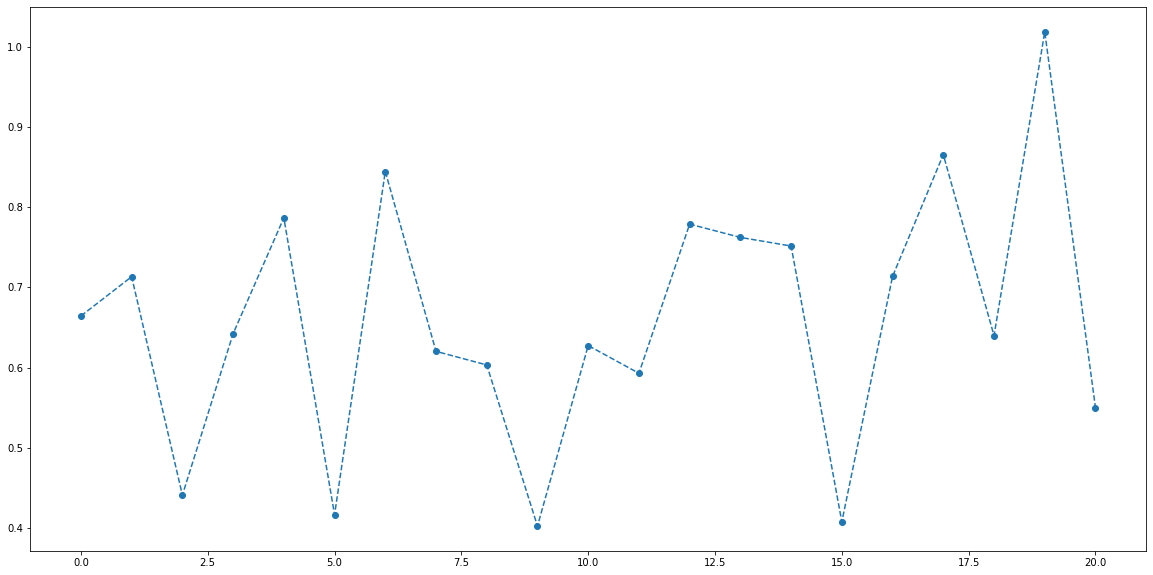

In [190]:
df = pd.read_csv('/Users/arianm/Documents/GitHub/ultraleap_analysis/data/raw_blocks/ul011/ft/m0s0/dist/dist_b1_ul011_m0s0_st_ft_right.csv', index_col= 0)
new(df, 'ft')

NameError: name 'tap_features' is not defined

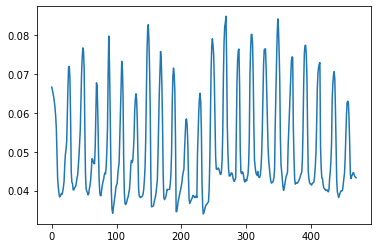

In [155]:
plt.plot(df['index_tip_thumb_tip'])
plt.plot(tap_features)

In [ ]:
{"ft": ["num_events", 
        "mean_max_dist", "sd_max_dist", "coef_var_max_dist", "slope_max_dist", 
        "mean_max_vel", "sd_max_vel", "coef_var_max_vel", "slope_max_vel", "mean_mean_vel", "sd_mean_vel", "coef_var_mean_vel", "slope_mean_vel", 
        "mean_deltat", "sd_deltat", "coef_var_deltat", "slope_deltat", 
        "mean_rms", "sd_rms", "slope_rms", "sum_rms"], 
"oc": ["num_events", 
        "mean_max_dist", "sd_max_dist", "coef_var_max_dist", "slope_max_dist", 
        "mean_max_vel", "sd_max_vel", "coef_var_max_vel", "slope_max_vel", "mean_mean_vel", "sd_mean_vel", "coef_var_mean_vel", "slope_mean_vel", 
        "mean_deltat", "sd_deltat", "coef_var_deltat", "slope_deltat", 
        "mean_rms", "sd_rms", "slope_rms", "sum_rms"], 
"ps": ["num_events", 
        "mean_max_ang", "sd_max_ang", "coef_var_max_ang", "slope_max_ang", 
        "mean_max_vel", "sd_max_vel", "coef_var_max_vel", "slope_max_vel", "mean_mean_vel", "sd_mean_vel", "coef_var_mean_vel", "slope_mean_vel", 
        "mean_deltat", "sd_deltat", "coef_var_deltat", "slope_deltat", 
        "mean_rms", "sd_rms", "slope_rms", "sum_rms"], 
"pt": ["psd_max", 
        "max_displ", "mean_displ", "sd_displ", "coef_var_displ"]}